In [1]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/data.csv').set_index('date')
df.index = pd.to_datetime(df.index)

In [3]:
widnow_size = 3
window = np.timedelta64(widnow_size,'D')

In [4]:
end_date = df.sample().index.values[0]
start_date = (end_date - window)

In [5]:
df[(df.index > start_date) & (df.index <= end_date)]

,Snow Depth (cm) Start of Day Values,Precipitation Increment (mm),Air Temperature Average (degC),Wind Direction Average (degree),Wind Speed Average (km/hr),rating,report,problems
date,,,,,,,,
2012-04-03,118.400000,1.466667,4.373333,226.000000,8.6,moderate,https://www.sierraavalanchecenter.org/content/...,[]
2012-04-04,113.133333,2.333333,-3.246667,250.000000,11.5,moderate,https://www.sierraavalanchecenter.org/content/...,[]
2012-04-05,115.800000,1.133333,-7.693333,256.666667,6.7,moderate,https://www.sierraavalanchecenter.org/content/...,[]


In [6]:
_df = df.drop(['report', 'problems', 'Wind Direction Average (degree)'], axis=1)
values = [0, 1, 2, 3, 4, 5]
conditions = (
    df['rating'] == 'na',
    df['rating'] == 'low',
    df['rating'] == 'moderate',
    df['rating'] == 'considerable',
    df['rating'] == 'high',
    df['rating'] == 'extream',
)
_df['rating'] = np.select(conditions, values)

start = _df.iloc[0].name
max_end = _df.iloc[-1].name
end = start + window
slices = []
not_even_slice = []
one_day = np.timedelta64(1,'D')

while end <= max_end:
    df_slice = _df[(_df.index > start) & (_df.index <= end)]
    if len(df_slice) == widnow_size:
        slices.append(df_slice)
        start = end
        end = start + window
    else:
        #not_even_slice.append(df_slice)
        start = start + one_day
        end = end + one_day

In [7]:
targets = slices[0]
for sample in slices[1:]:
    targets = pd.concat([targets, sample.iloc[-1:]])

In [8]:
dataset = []
for sample in slices:
    flat_sample = sample.to_numpy().flatten().tolist()
    dataset.append([*flat_sample[:-1], flat_sample[-1]])

In [9]:
class_idx = 5*widnow_size - 1 # 5 features
assert len(dataset[0]) == class_idx + 1, len(dataset[0])

In [10]:
df = pd.DataFrame(dataset)

In [11]:
df = df[df[class_idx] != 0]

In [12]:
lables, counts = np.unique(df.iloc[...,class_idx], return_counts=True)
lables = lables.astype(int)
counts = counts[(lables != 0) & (lables != 5)]
counts

array([179, 292,  89,  20])

In [13]:
test_set_size = [ int(.1 * count) for count in counts]
test_set_size

[17, 29, 8, 2]

In [14]:
test_df = pd.DataFrame()
test_df = pd.concat([test_df, df[df[class_idx]==1].sample(test_set_size[0])])
test_df = pd.concat([test_df, df[df[class_idx]==2].sample(test_set_size[1])])
test_df = pd.concat([test_df, df[df[class_idx]==3].sample(test_set_size[2])])
test_df = pd.concat([test_df, df[df[class_idx]==4].sample(test_set_size[3])])

In [15]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
262,90.200000,0.000000,0.906667,9.233333,2.0,87.666667,0.200000,1.906667,7.666667,2.0,86.333333,0.200000,0.160000,8.933333,1.0
7,73.666667,0.200000,2.373333,4.300000,1.0,73.266667,0.000000,2.113333,6.433333,1.0,72.600000,0.000000,4.586667,3.100000,1.0
299,44.133333,0.000000,0.613333,4.966667,1.0,43.333333,0.000000,3.560000,5.700000,1.0,42.133333,0.000000,6.053333,3.666667,1.0
106,176.666667,5.733333,-1.426667,8.400000,1.0,175.800000,0.000000,0.666667,6.100000,2.0,174.266667,5.933333,0.900000,8.233333,1.0
476,55.466667,1.200000,5.293333,12.250000,2.0,53.933333,6.666667,0.060000,11.800000,2.0,61.466667,1.200000,-0.566667,6.150000,1.0


In [16]:
train_df = df.drop(test_df.index)

In [17]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,43.733333,5.466667,-7.420000,11.900000,1.0,41.533333,9.200000,-5.860000,15.966667,3.0,44.200000,3.733333,-2.813333,6.400000,1.0
1,40.866667,14.266667,-0.206667,8.266667,1.0,50.733333,9.866667,-6.540000,12.433333,3.0,65.666667,8.400000,-8.086667,7.300000,2.0
2,65.200000,18.800000,-3.260000,10.200000,2.0,74.800000,44.600000,-7.293333,11.900000,3.0,105.133333,3.066667,-11.266667,3.700000,2.0
3,100.666667,3.400000,-2.993333,4.633333,1.0,91.933333,1.533333,0.900000,6.100000,1.0,88.933333,0.000000,2.020000,10.400000,1.0
4,77.000000,15.066667,-1.653333,12.466667,2.0,85.800000,0.000000,-9.320000,2.533333,2.0,83.266667,0.000000,-7.046667,3.966667,1.0


In [18]:
train_df = train_df.reset_index().drop('index', axis=1)
test_df = test_df.reset_index().drop('index', axis=1)

In [19]:
X = train_df.iloc[...,:class_idx-1].to_numpy()
Y = train_df.iloc[...,class_idx].to_numpy().astype(int)

In [20]:
X_test = test_df.iloc[...,:class_idx-1].to_numpy()
Y_test = test_df.iloc[...,class_idx].to_numpy().astype(int)

In [21]:
from sklearn import tree

In [22]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

In [23]:
clf.predict(X_test)

array([2, 1, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 1, 3, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 1, 1, 3, 2, 1, 2, 3, 4])

In [24]:
Y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4])

In [25]:
clf.score(X_test, Y_test)

0.6428571428571429

In [26]:
np.unique(Y, return_counts=True)

(array([1, 2, 3, 4]), array([162, 263,  81,  18]))

In [27]:
np.unique(Y_test, return_counts=True)

(array([1, 2, 3, 4]), array([17, 29,  8,  2]))

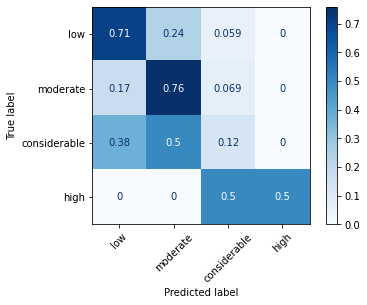

In [28]:
class_names=['low', 'moderate', 'considerable', 'high']
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    Y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize='true'
)
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=45);

In [29]:
clf = tree.DecisionTreeClassifier(class_weight='balanced')
clf = clf.fit(X, Y)
clf.score(X_test, Y_test)

0.7142857142857143

In [37]:
clf = tree.DecisionTreeClassifier(max_depth=3, class_weight='balanced')
clf.fit(X, Y).score(X_test, Y_test)

0.8035714285714286

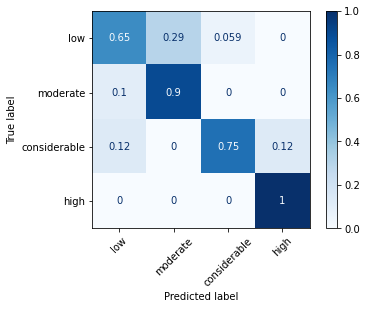

In [38]:
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    Y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize='true'
)
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=45);

In [32]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf.fit(X, Y).score(X_test, Y_test)

0.6964285714285714

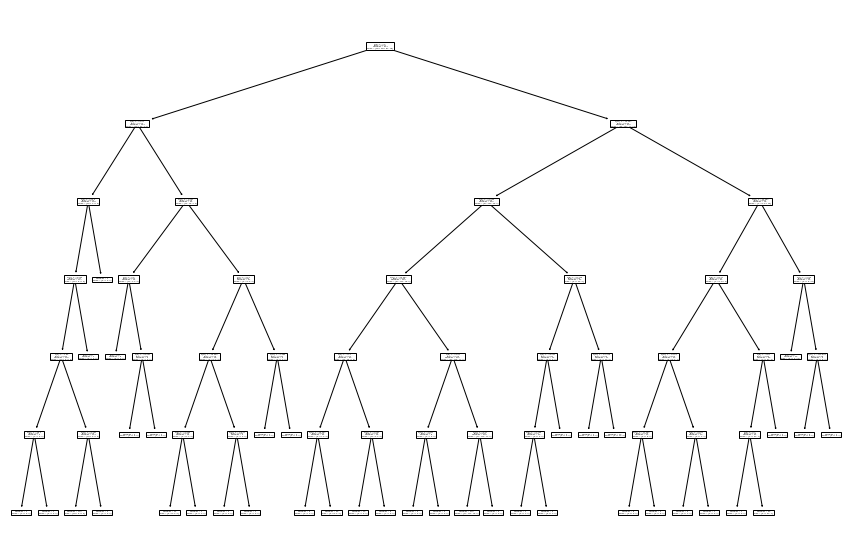

In [33]:
plt.figure(figsize=(15,10))
tree.plot_tree(clf);

In [34]:
from sklearn.model_selection import cross_val_score
clf = tree.DecisionTreeClassifier(max_depth=6)
cross_val_score(clf, X, Y, cv=10)

array([0.66037736, 0.71698113, 0.8490566 , 0.73584906, 0.73076923,
       0.73076923, 0.78846154, 0.73076923, 0.73076923, 0.75      ])

In [35]:
depths = list(range(1, 15))
test_acs = []
train_acs = []
for depth in depths:
    clf = tree.DecisionTreeClassifier(max_depth=depth, class_weight='balanced')
    test_ac = clf.fit(X, Y).score(X_test, Y_test)
    test_acs.append(test_ac)
    train_ac = clf.score(X, Y)
    train_acs.append(train_ac)

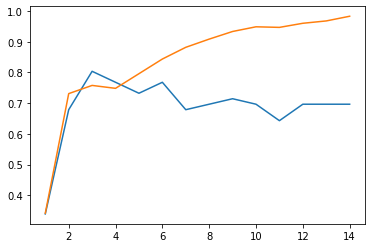

In [36]:
plt.plot(depths, test_acs)
plt.plot(depths, train_acs)